In [ ]:
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import sys
from numpy import dot, exp, mgrid, pi, ravel, square, uint8, zeros, pad
from glob import glob



import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix


# 1. Dataset:

source: 
- https://www.geeksforgeeks.org/detect-and-recognize-car-license-plate-from-a-video-in-real-time/
- https://pyimagesearch.com/2020/09/21/opencv-automatic-license-number-plate-recognition-anpr-with-python/
- https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.htmlhttps://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html


## Preprocesamiento:
1.  Investigación del método “contorno-placa” propuesto en una imagen:
 - i. Prepara imagen en escala de grises
 -ii. Aplicar Filtro Gaussiano ( Eliminar ruido y suavizar la imagen)
 - iii. Aplicar Filtro Sobel Vertical X(Detectar bordes verticales)
 - iv. Aplicar Umbral OTSU(Para binarizar y segmentar imagen)
 - v. Aplicar Operación Closing( Para realzar la forma de la placa)
 - vi. Aplicar Operación Opening( Para eliminar puntos negros y realzar la forma de la placa)
 - vii. Obtener Contorno de la placa(Imagen Mascara):
    1. Opción 1: Dividir imagen en 2 y usar la parte inferior. Está opción fue la aplicada debido a que analizando las imágenes se encontró que el contorno de las imágenes se encontraron en la parte inferior de las imágenes procesadas.
    2. Opción 2: Uso del algoritmo moore, square tracing. Está opción aún está en proceso debido a tiempo de prueba y ajuste del algoritmo.
    
## Creacion de dataset:
2. Creación de dataset:
 - i. Aplicamos el método “contorno-placa” para encontrar la imagen mascara de todas las imágenes originales.
 - ii. Aplicar Algoritmo Bounding Box para encontrar las coordenadas del contorno de la placa.
   1. Se aplicó técnicas estadísticas cómo media, outliers, para validar el valor del ancho(W - Width) y largo(H - Height) utilizado.
 - iii. Crear dataset de imágenes fondo.
 - iv. Crear dataset de imágenes placa.

In [124]:
# minimum area of the plate
min_area = 100
 
# maximum area of the plate
max_area = 7000 

element_structure = cv2.getStructuringElement(shape = cv2.MORPH_RECT, ksize =(30, 4))
sigma = 1/(2*pi)

def preprocess(input_img):
    imgBlurred = cv2.GaussianBlur(input_img, (7, 7), sigma)

    # convert to gray
    # gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY)
     
    # sobelX to get the vertical edges
    sobelx = cv2.Sobel(imgBlurred, cv2.CV_8U, 1, 0, ksize = 3, borderType=cv2.BORDER_DEFAULT) 

    # otsu's thresholding
    ret2, threshold_img = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
 
    element = element_structure
    morph_n_thresholded_img_close = cv2.morphologyEx(src = threshold_img, op = cv2.MORPH_CLOSE, kernel = element)
    #morph_n_thresholded_img_close_ero = cv2.erode(morph_n_thresholded_img_close,kernel = element, iterations = 1)
    #morph_n_thresholded_img_close_dil = cv2.dilate(morph_n_thresholded_img_close_ero,kernel = element, iterations = 1)
    
    morph_n_thresholded_img_open = cv2.morphologyEx(src = morph_n_thresholded_img_close, op = cv2.MORPH_OPEN, kernel = element)
    
    return morph_n_thresholded_img_open

def extract_contours(after_preprocess):
     
    contours1, _ = cv2.findContours(after_preprocess, mode = cv2.RETR_EXTERNAL,method = cv2.CHAIN_APPROX_NONE)
    return contours1

def clean_plate(plate):

    thresh = cv2.adaptiveThreshold(plate, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if contours:
        areas = [cv2.contourArea(c) for c in contours]
         
        # index of the largest contour in the area
        # array
        max_index = np.argmax(areas) 

        max_cnt = contours[max_index]
        max_cntArea = areas[max_index]
        x, y, w, h = cv2.boundingRect(max_cnt)
        rect = cv2.minAreaRect(max_cnt)
         
        if not preRatioCheck(max_cntArea, plate.shape[1], plate.shape[0]):
            return plate, False, None
         
        return plate, True, [x, y, w, h]
     
    else:
        return plate, False, None

def preRatioCheck(area, width, height):
         
    min = min_area
    max = max_area
 
    ratioMin = 2
    ratioMax = 6
 
    ratio = float(width) / float(height)
    
    if ratio < 1:
            ratio = 1 / ratio
            
    print(area, ratio) 
    if (area < min or area > max) or (ratio < ratioMin or ratio > ratioMax):
        return False
     
    return True

def validateRatio(rect):
    (x, y), (width, height), rect_angle = rect
    print("Parameters: ", width * height, width, height, rect_angle)
    

     
    if (height == 0 or width == 0):
        return False
    
    area = width * height
      
    min = min_area
    max = max_area
    ratioMin = 2
    ratioMax = 6
    ratio = float(width) / float(height)
    
    if ratio < 1:
        ratio = 1 / ratio
        
    if (area < min or area > max) or (ratio < ratioMin or ratio > ratioMax):
        return False
     
    return True
    
def check_plate(input_img, contour):
     
    min_rect = cv2.minAreaRect(contour)
    print(min_rect)
    print("validateRatio: ", validateRatio(min_rect))
    if validateRatio(min_rect):
        x, y, w, h = cv2.boundingRect(contour)
        after_validation_img = input_img[y:y + h, x:x + w]
        after_clean_plate_img, plateFound, coordinates = clean_plate(after_validation_img)
        #print(plateFound, "")
        if plateFound:
            return after_clean_plate_img, plateFound, [x, y, w, h]   
    return None, None, None

def find_plates(input_img):
    plates = []
    char_on_plate = []
    corresponding_area = []
 
    after_preprocess = preprocess(input_img)
    possible_plate_contours = extract_contours(after_preprocess)
    print(len(possible_plate_contours))
    i=1
    for cnts in possible_plate_contours:
        
        print(i, len(cnts))
        
        plate, plateFound, coordinates = check_plate(input_img, cnts)
        print("Placa encontrada: ", plateFound)
        i+=1
        if plate is not None:
            plates.append(plate)
            char_on_plate.append(plateFound)
            corresponding_area.append(coordinates)
 
    if (len(plates) > 0):
        return plates, corresponding_area
     
    else:
        return None

Tamño de la image:  (240, 352)


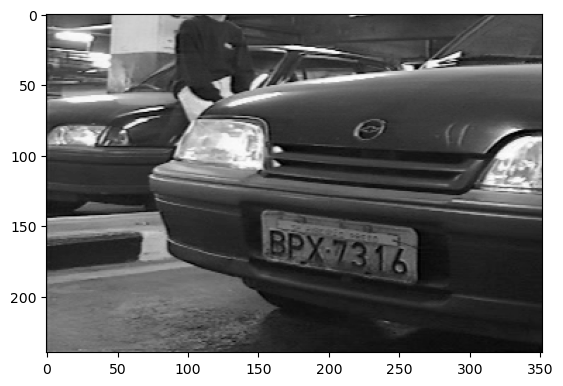

In [117]:
img1 = imageio.imread('../orig_0018.png')
print("Tamño de la image: ", img1.shape)
plt.imshow(img1, cmap="gray")
plt.show()

8 239


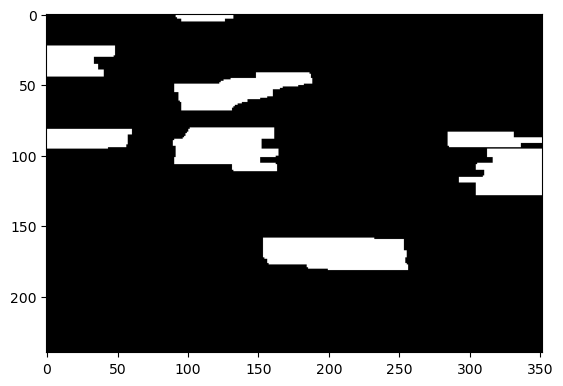

In [118]:
morph_n_thresholded_img_open = preprocess(img1)
contour = extract_contours(morph_n_thresholded_img_open)
print(len(contour), len(contour[0]))
plt.imshow(morph_n_thresholded_img_open, cmap="gray")
plt.show()

In [119]:
img_contours = np.zeros(img1.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contour, 0, (255,255,25), 3)
#save image
cv2.imwrite('contours.png',img_contours) 

True

In [121]:
rect = cv2.minAreaRect(contour[0])
rect

((205.0, 170.0), (22.0, 102.0), 90.0)

In [93]:
cont = contour[0]
rect = cv2.minAreaRect(cont)
print(rect)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img1,[box],0,(0,0,255),2)
cv2.imwrite('contours.png',img1) 

((205.0, 170.0), (22.0, 102.0), 90.0)


True

In [ ]:
plate_img, plate_coordinates = find_plates(img1)

In [178]:
plate_img[0], plate_coordinates[0]

(Array([[104, 113, 105, ...,  90,  91,  90],
        [ 97, 108, 104, ...,  98, 100, 102],
        [103, 113, 100, ...,  93,  94,  98],
        ...,
        [ 23,  22,  21, ...,   9,  42, 105],
        [ 31,  30,  29, ...,  11,  26,  91],
        [ 36,  35,  33, ...,  12,  14,  75]], dtype=uint8),
 [154, 159, 103, 23])

In [442]:
contour[4].shape

(156, 1, 2)

In [ ]:
plt.imshow(contor[0], cmap="gray")
plt.show()

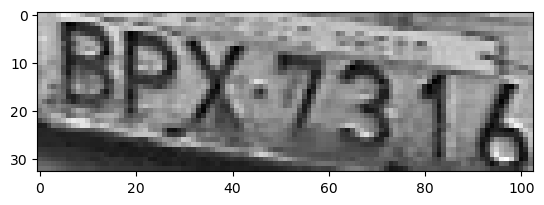

In [179]:
plt.imshow(img1[plate_coordinates[0][1]-7:plate_coordinates[0][1]-7+plate_coordinates[0][3]+10,plate_coordinates[0][0]:plate_coordinates[0][0] + plate_coordinates[0][2]], cmap="gray")
plt.show()

In [2]:
#Database BD2 description:
#./BD2/conjunto de datos
#./BD2/placas

#Setting print options with threshold = 0 (For not see any parameter during print command execution)
#np.set_printoptions(threshold=0)

route_mask = '../BD2/placas/mask_'
route_auto_mask = '../BD2/placas_automask/automask_'
route_imagen = '../BD2/placas/orig_'
route_text_train = '../BD2/conjunto de datos/entrenamiento'
#route_text_test = './BD2/

route_results_train_text =  '../BD2/results/text/entrenamiento'
route_results_train_imagePlaca =  '../BD2/results/imagePlaca/'
route_results_train_imageFondo =  '../BD2/results/imageFondo/'

In [180]:
def maxWHCoordinatexBBox(ex):
    """ 
    ex: training number. Values: 1,2,3
    img: imagen
    
    """
    # Load training imagens:
    # Load imagen ids to calculate Width and Height and coordinates according training images of ex training number
    
    # route_text_train = './BD2/conjunto de datos/entrenamiento'
    train_images = np.loadtxt(route_text_train+str(ex)+'.txt',dtype=str)
    # 
    # matrix_results: Image name ID, x, y, w, h
    matrix_results = np.array([0]*5*train_images.shape[0]).reshape(train_images.shape[0],5)

    # Initialization for Width(W) and Height(H)
    W = 0
    H = 0

    # img_nom[14:18] is the position of imagen ID number
    
    l_x = []
    l_y = []
    l_w = []
    l_h = []
    
    for i, img_name in enumerate(train_images):
        # route_mask = './BD2/placas/mask_'
        #img = imageio.imread(route_mask+img_name[14:18] +'.png')
        
        # route_auto_mask = './BD2/placas_automask/automask_'
        img = imageio.imread(route_imagen+img_name[14:18] +'.png')
        print(route_imagen+img_name[14:18] )
        # min_x,min_y,max_x,max_y = coordinatesBBox(img)
        _, plate_coordinates = find_plates(img)
        # print(min_x,min_y,max_x,max_y)
      
        matrix_results[i][0] = img_name[14:18]
        matrix_results[i][1] = plate_coordinates[0][0] # coordinate x
        matrix_results[i][2] = plate_coordinates[0][1] # coordinate y
        matrix_results[i][3] = plate_coordinates[0][2] # coordinate w
        matrix_results[i][4] = plate_coordinates[0][3] # coordinate h
        
        l_x.append(plate_coordinates[0][0])
        l_y.append(plate_coordinates[0][1])
        l_w.append(plate_coordinates[0][2])
        l_h.append(plate_coordinates[0][3])
        
        #if (abs(max_x-min_x) >= W):
        #    W = abs(max_x-min_x)
        #if (abs(max_y-min_y) >= H):
        #    H = abs(max_y-min_y)
    # route_results_train_text =  './BD2/results/text/entrenamiento'
    np.savetxt(route_results_train_text+str(ex)+'_dat.txt', matrix_results, fmt='%s')
    
    
    df_xy = pd.DataFrame(columns = ["x", "y", "w", "h"])
    df_xy["x"] = l_x
    df_xy["y"] = l_y
    df_xy["w"] = l_w
    df_xy["h"] = l_h
    W = int(df_xy.mean()["w"])
    H = int(df_xy.mean()["h"])
    
    return W, H, df_xy


Tamño de la image:  (240, 352)


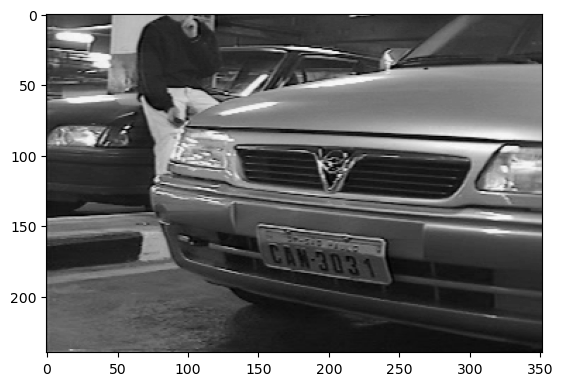

In [304]:
img = imageio.imread('../BD2/placas/orig_0003.png')
print("Tamño de la image: ", img.shape)
plt.imshow(img, cmap="gray")
plt.show()

(240, 352)


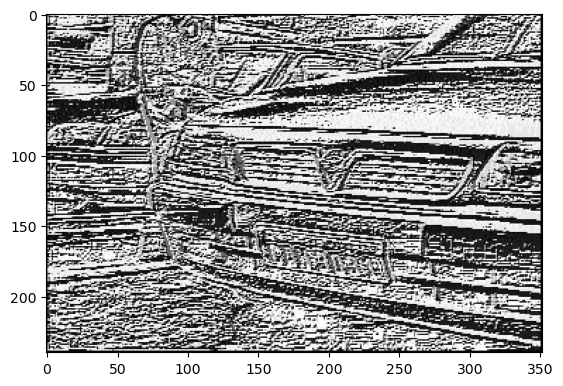

In [306]:
img_LBP = algLBPnxn(img, 3)
print(img_LBP.shape)
plt.imshow(img_LBP, cmap="gray")
plt.show()

In [ ]:
ex = 1
W, H, df_xy = maxWHCoordinaimg_LBPox(ex)

In [155]:
print(W, H)
df_xy.head()

101 29


,x,y,w,h
0,151,156,95,34
1,138,175,105,41
2,124,162,101,23
3,139,129,103,27
4,173,127,114,40


In [156]:
df_xy.describe()

,x,y,w,h
count,100.00000,100.000000,100.000000,100.000000
mean,137.79000,145.750000,101.260000,29.720000
std,51.99015,13.056501,26.174867,7.253115
min,0.00000,89.000000,32.000000,7.000000
25%,108.00000,138.000000,91.000000,25.000000
50%,146.50000,146.000000,98.500000,30.000000
75%,171.00000,153.000000,110.000000,34.250000
max,300.00000,176.000000,198.000000,43.000000


In [193]:

# Creando subimagenes de placas y de fondo de tamaño (H+4) x (W+4) solo para el entrenamiento

def subImagesFondoPlaca(ex, W, H):
    
    # Now we will do some statistic to W and H for finding the accurate them
    # Find W, H values
    #W, H = maxWHCoordinatexBBox(ex)
    #print("Tamaño de dezplazamiento: ",W,H)
    
    # Loading matrix results: Image name ID, xmin, ymin, xmax, ymax
    # route_results_train_text =  './BD2/results/text/entrenamiento'
    ent_a = np.loadtxt(route_results_train_text + str(ex) +'_dat.txt',dtype=int)
    
    for k, img_nom in enumerate(ent_a):
        # route_imagen = './BD2/placas/orig_'
        img = imageio.imread(route_imagen +'0'*(4-len(str(img_nom[0]))) + str(img_nom[0]) +'.png')
        
        print("Tamaño de la Imagen Original: ", img.shape) 
        
        ###### Cutting placa imagen #########
        desde_x = img_nom[1]
        desde_y = img_nom[2]
        w = img_nom[3]
        h = img_nom[4]

        img_sub = np.zeros([h+4, w+4], dtype=int)
        print("Tamaño de la Sub-Imagen Placa: ",img_sub.shape, w, h)      
        print("Coordinates from where we start to cut: ",desde_x, desde_y)
        
        for i in range(0,h):
            for j in range(0,w):
                img_sub[i,j] = img[desde_y+i, desde_x+j]
                #print(i,j,desde_x, desde_y,desde_x+i, desde_y+j )
                
        # Saving subimagen placa
        #route_results_train_imagePlaca =  './BD2/results/imagePlaca/'
        imageio.imwrite(route_results_train_imagePlaca +'orig_'+'0'*(4-len(str(img_nom[0])))+str(img_nom[0])+'_placa.png',img_sub)
        
      
        ###### Cutting fondo imagen ##############
        for i in range( 0 , img.shape[0]-H-4, H+4):
            for j in range(0 , img.shape[1]-W-4, W+4):
                if ( (i+H+4 <= desde_y and j+W+4 <= img.shape[1]) 
                    or (i+H+4 <= img.shape[0] and j+W+4 <= desde_x)  
                    or (i+H+4 <= img.shape[0] and j > desde_x++W+4)  
                    or ( i+H+4 <= img.shape[0] and i>desde_x++H+4 and j+W+4 <= img.shape[1]) ):
                                        
                    img_sub = np.zeros([ H+4 , W+4 ], dtype=int)
                    
                    print()
                    print("Tamaño de la Sub-Imagen Fondo: ",img_sub.shape)
                    
                    for m in range(i, H+4+i):
                        for n in range(j, W+4+j):
                            img_sub[m-i,n-j] = img[m,n]
                    
                    # Saving subimagen fondo
                    # route_results_train_imageFondo =  './BD2/results/imageFondo/'
                    imageio.imwrite(route_results_train_imageFondo +'orig_'+'0'*(4-len(str(img_nom[0])))+str(img_nom[0])+'_'+str(i)+'_'+str(j)+'_fondo.png',img_sub)
    


In [ ]:
subImagesFondoPlaca(1, W, H)

In [195]:
# 1. LBP Algorithm

def algLBPnxn(image, n):
    """
    n: odd number(impar), n=3,5,6,9,11,...
    
    """
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # imgLBP: matrix of descriptor after applying comparinson by threshold    
    imgLBP = np.zeros_like(image)
    neighboor = n 
    num = 0
    for ih in range(0,image.shape[0]-2):
        for iw in range(0,image.shape[1]-2):
            
            ### Step 1: Obtain binary vector from n by n pixel matrix
            img_nxn = image[ih:ih+neighboor,iw:iw+neighboor]
            #center = img_nxn[(n+1)*(n-1)/2 ,(n+1)*(n-1)/2]
            center = img_nxn[1,1]
            img_binanry_matrix = (img_nxn >= center)*1.0
            
            # Also we can order in anti-counterclock way: img01_vector = img01.T.flatten()
            # Deleting 
            img_binanry_vector = np.delete(img_binanry_matrix.flatten(),n+1)
            
            ### Step 2: Convert binary to Decimal
            # If there is somthing to convert
            img_binanry_vector_index = np.where(img_binanry_vector)[0]
            
            if len(img_binanry_vector_index) >= 1:
                img_des = np.sum(2**img_binanry_vector_index)
            else:
                img_des = 0
                
            imgLBP[ih+1,iw+1] = img_des
            
    return imgLBP


def algDesToFrec(img, n):
    des = algLBPnxn(img, n)
    # aplanando des previo para calculo de frecuencia, tiene 126 x 126 = 15876 dimensiones
    des_flatted = [item for sublist in des for item in sublist]
    # print("des plano =", des_fla)
    
    # calculando frecuencia para aplicar reduccion dimensional a 2^8 = 256 dimensiones
    dic_fre_des = {}
    for i in des_flatted:
        if i in dic_fre_des:
            dic_fre_des[i] += 1
        else:
            dic_fre_des[i] = 1
  
    return dic_fre_des

In [283]:
# 3. Calculating description and frecuency for all images placa and images fondo

##### Calculo de LBP para las imagenes Placa
# numero de dimensiones del descriptor para cada imagen (entre 1 y 256 y potencia de 2)
num_dimensiones = 256


route_results_train_text_results =  '../BD2/results/text/'
route_results_train_text =  '../BD2/results/text/entrenamiento'
route_results_train_imagePlaca =  '../BD2/results/imagePlaca/'
route_results_train_imageFondo =  '../BD2/results/imageFondo/'

ent_a = np.loadtxt(route_results_train_text+str(ex)+'_dat.txt',dtype=int)

ent = np.zeros([ent_a.shape[0], num_dimensiones], dtype=int)

print(ent.shape)

for k, img_nom in enumerate(ent_a):

    img = imageio.imread(route_results_train_imagePlaca+'orig_'+'0'*(4-len(str(img_nom[0])))+str(img_nom[0])+'_placa.png')
  
    # Inicializa la matriz de descriptores con valores cero
    # Aplica el algoritmo LBP, devuelve la matriz des con valores binarios
    # Convierte la matriz des a valores decimales
    # Aplana des para prepararla para calculo de frecuencia, des tiene (img.shape[0]-2) x (img.shape[1]-2) dimensiones
    # Calculando frecuencia para aplicar reduccion dimensional a 2^8 = 256 dimensiones, devuelve free_des_fla
    dic_fre_des = algDesToFrec(img,3)
    for posi in sorted(dic_fre_des):
        # PARTE 1
        # Punto 5: Cálculo del descriptor en función a resultados del histograma
        # guardando dato de entrenamiento (las frecuencias)
        ent[k, posi] =  ent[k, posi] + dic_fre_des[posi]
    #print(ent[k,posi])
    
    # Guardando datos resultado de entrenamiento en archivo externo para uso en proceso de clasificación
np.savetxt(route_results_train_text_results+'Project4_Mejorado'+str(num_dimensiones)+'d_placa.txt', ent, fmt='%d')


(100, 256)


In [284]:


##### Calculo de LBP para las imagenes Fondo
# numero de dimensiones del descriptor para cada imagen (entre 1 y 256 y potencia de 2)
num_dimensiones = 256

route_results_train_text_results =  '../BD2/results/text/'
route_results_train_text =  '../BD2/results/text/entrenamiento'
route_results_train_imagePlaca =  '../BD2/results/imagePlaca/'
route_results_train_imageFondo =  '../BD2/results/imageFondo/'


contenido = glob(route_results_train_imageFondo+'*.png')
print("Num imagenes fondo para entrenamiento =", len(contenido))

# inicializando matriz para resultados del entrenamiento: clases fondo, contiene len(contenido) imagenes,
# cada imagen contiene un vector descriptor de num_dimensiones
ent = np.zeros([len(contenido), num_dimensiones], dtype=int)
print(ent.shape)
print("")


for k, img_nom in enumerate(contenido):

    img = imageio.imread(img_nom)
    
    # Inicializa la matriz de descriptores con valores cero
    # Aplica el algoritmo LBP, devuelve la matriz des con valores binarios
    # Convierte la matriz des a valores decimales
    # Aplana des para prepararla para calculo de frecuencia, des tiene (img.shape[0]-2) x (img.shape[1]-2) dimensiones
    # Calculando frecuencia para aplicar reduccion dimensional a 2^8 = 256 dimensiones, devuelve free_des_fla
    dic_fre_des = algDesToFrec(img,3)

    #intervalos = 256 // num_dimensiones
    intervalos = 256
    
    for posi in sorted(dic_fre_des):  
        ent[k,posi] =  ent[k,posi] + dic_fre_des[posi]

    
    # Guardando datos resultado de entrenamiento en archivo externo para uso en proceso de clasificación
np.savetxt(route_results_train_text_results+'Project4_Mejorado'+str(num_dimensiones)+'d_fondo.txt', ent, fmt='%d')


Num imagenes fondo para entrenamiento = 1837
(1837, 256)



In [2]:
# Cargando parametros generales realizado en el entrenamiento

#num_dimensiones = 128
num_dimensiones = 256

num_dimensiones = 256

route_results_train_text_results =  '../BD2/results/text/'
route_results_train_text =  '../BD2/results/text/entrenamiento'
route_results_train_imagePlaca =  '../BD2/results/imagePlaca/'
route_results_train_imageFondo =  '../BD2/results/imageFondo/'

route_mask = '../BD2/placas/mask_'
route_auto_mask = '../BD2/placas_automask/automask_'
route_imagen = '../BD2/placas/orig_'
route_text_train = '../BD2/conjunto de datos/entrenamiento'
route_text_test = '../BD2/conjunto de datos/prueba'

route_results_train_text =  '../BD2/results/text/entrenamiento'
route_results_train_imagePlaca =  '../BD2/results/imagePlaca/'
route_results_train_imageFondo =  '../BD2/results/imageFondo/'
route_results_train =  '../BD2/results/text/'


route_results_test =  '../BD2/results/detection/'

# Cargando datos resultado de entrenamiento en archivo externo para uso en proceso de clasificación
ent_arr_p = np.loadtxt(route_results_train_text_results+'Project4_Mejorado'+str(num_dimensiones)+'d_placa.txt')
ent_arr_f = np.loadtxt(route_results_train_text_results+'Project4_Mejorado'+str(num_dimensiones)+'d_fondo.txt')

umbral = 50
VP = 0
FP = 0
FN = 0
VN = 0

W= 101
H= 29
print(ent_arr_p.shape)
print(ent_arr_f.shape)
print(W,H)

(100, 256)
(1837, 256)
101 29


In [3]:
plate_arr = np.c_[ent_arr_p, np.ones(ent_arr_p.shape[0])]
fondo_arr = np.c_[ent_arr_f, np.zeros(ent_arr_f.shape[0])]

dataset_arr = np.vstack((plate_arr, fondo_arr))
print(dataset_arr.shape, len(dataset_arr))

(1937, 257) 1937


In [119]:
randomize = np.arange(len(dataset_arr))
np.random.shuffle(randomize)
dataset_arr = dataset_arr[randomize]
col = [ "Bit"+str(i) for i in range(256)]
col.append("class")
df = pd.DataFrame(dataset_arr, columns = [col])
df.head()

,Bit0,Bit1,Bit2,Bit3,Bit4,Bit5,Bit6,Bit7,Bit8,Bit9,...,Bit247,Bit248,Bit249,Bit250,Bit251,Bit252,Bit253,Bit254,Bit255,class
0,363.0,7.0,9.0,11.0,10.0,2.0,12.0,52.0,127.0,13.0,...,121.0,188.0,19.0,5.0,6.0,15.0,4.0,9.0,181.0,0.0
1,406.0,11.0,5.0,10.0,25.0,5.0,13.0,35.0,75.0,8.0,...,135.0,44.0,13.0,0.0,24.0,32.0,23.0,41.0,368.0,0.0
2,388.0,9.0,10.0,8.0,6.0,3.0,8.0,87.0,163.0,17.0,...,135.0,106.0,22.0,1.0,13.0,15.0,7.0,10.0,260.0,0.0
3,436.0,15.0,10.0,16.0,16.0,3.0,15.0,35.0,120.0,35.0,...,157.0,76.0,29.0,3.0,33.0,23.0,10.0,28.0,283.0,0.0
4,361.0,5.0,19.0,5.0,19.0,1.0,11.0,31.0,63.0,6.0,...,126.0,72.0,28.0,2.0,29.0,31.0,30.0,22.0,238.0,0.0


# 2. EDA

1. Checking Nulls 
dataset.isnull().sum()

2. Data Information revision

dataset.info()
dataset.describe()

We need to check if there is outliers

3. Target value revision

dataset["class"].value_counts()
dataset["class"].value_counts().sort_index().plot.bar()

dataset.groupby('class').mean()

4. Checking correlation

plt.subplots(figsize=(12,8))
sns.heatmap(dataset.corr(), annot=True)

dataset.corr()['pelvic_incidence'].sort_values(ascending=False) 

5. Checking data distribution

dataset.hist(figsize=(15,12),bins = 20, color="#007959AA")
plt.title("Features Distribution")
plt.show()

Split data for analysis:

vis1 = dataset.iloc[:,[1,2,3,4,5,6,12]]
vis2 = dataset.iloc[:,[7,8,9,10,11,12]]

sns.pairplot(vis1, hue="class")
sns.pairplot(vis2, hue="class")

plt.subplots(figsize=(15,6))
dataset.boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)





In [120]:
df.head()

,Bit0,Bit1,Bit2,Bit3,Bit4,Bit5,Bit6,Bit7,Bit8,Bit9,...,Bit247,Bit248,Bit249,Bit250,Bit251,Bit252,Bit253,Bit254,Bit255,class
0,363.0,7.0,9.0,11.0,10.0,2.0,12.0,52.0,127.0,13.0,...,121.0,188.0,19.0,5.0,6.0,15.0,4.0,9.0,181.0,0.0
1,406.0,11.0,5.0,10.0,25.0,5.0,13.0,35.0,75.0,8.0,...,135.0,44.0,13.0,0.0,24.0,32.0,23.0,41.0,368.0,0.0
2,388.0,9.0,10.0,8.0,6.0,3.0,8.0,87.0,163.0,17.0,...,135.0,106.0,22.0,1.0,13.0,15.0,7.0,10.0,260.0,0.0
3,436.0,15.0,10.0,16.0,16.0,3.0,15.0,35.0,120.0,35.0,...,157.0,76.0,29.0,3.0,33.0,23.0,10.0,28.0,283.0,0.0
4,361.0,5.0,19.0,5.0,19.0,1.0,11.0,31.0,63.0,6.0,...,126.0,72.0,28.0,2.0,29.0,31.0,30.0,22.0,238.0,0.0


In [121]:
# 1. Checking Nulls dataset.isnull().sum()
null_finder = df.isnull().sum()
list(set(np.where(null_finder == 0, "true", "false")))

['true']

In [122]:
# 2. Data Information revision
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Columns: 257 entries, ('Bit0',) to ('class',)
dtypes: float64(257)
memory usage: 3.8 MB


In [123]:
df.describe()

,Bit0,Bit1,Bit2,Bit3,Bit4,Bit5,Bit6,Bit7,Bit8,Bit9,...,Bit247,Bit248,Bit249,Bit250,Bit251,Bit252,Bit253,Bit254,Bit255,class
count,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,...,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000
mean,377.553433,10.195147,11.124935,11.410428,11.574600,2.365514,13.255034,53.163655,94.365514,17.878162,...,110.905008,111.220444,23.057821,4.092927,23.246257,22.156944,15.189468,22.408363,308.202375,0.051626
std,36.126433,4.928111,8.693880,5.369542,5.180197,1.903294,5.982326,28.917229,28.261811,7.825685,...,27.867126,84.654276,11.110999,3.030771,10.820940,10.137186,8.060831,9.725148,123.225371,0.221328
min,94.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,...,4.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,78.000000,0.000000
25%,361.000000,7.000000,6.000000,8.000000,8.000000,1.000000,9.000000,33.000000,76.000000,12.000000,...,94.000000,63.000000,15.000000,2.000000,16.000000,15.000000,10.000000,16.000000,234.000000,0.000000
50%,378.000000,10.000000,9.000000,11.000000,11.000000,2.000000,13.000000,47.000000,92.000000,17.000000,...,111.000000,87.000000,21.000000,4.000000,21.000000,21.000000,14.000000,21.000000,283.000000,0.000000
75%,393.000000,13.000000,14.000000,15.000000,15.000000,3.000000,17.000000,69.000000,111.000000,23.000000,...,129.000000,134.000000,29.000000,6.000000,29.000000,28.000000,19.000000,28.000000,341.000000,0.000000
max,748.000000,32.000000,105.000000,53.000000,33.000000,14.000000,46.000000,258.000000,222.000000,57.000000,...,235.000000,933.000000,106.000000,24.000000,82.000000,98.000000,103.000000,89.000000,1454.000000,1.000000


In [124]:
# We need to check if there is outliers
# 3. Target value revision

df["class"].value_counts()


(class,)
0.0         1837
1.0          100
dtype: int64

<AxesSubplot:xlabel='(class,)'>

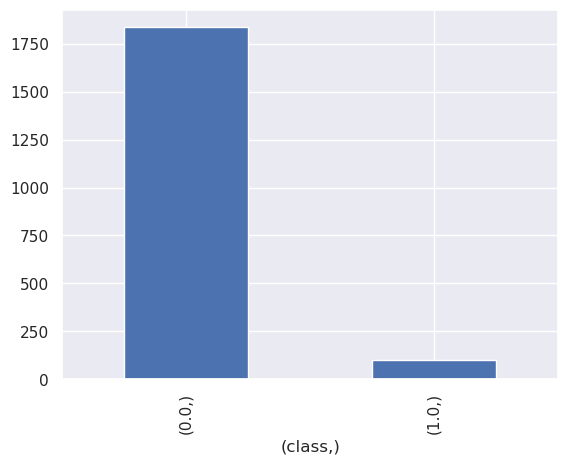

In [125]:
df["class"].value_counts().sort_index().plot.bar()

<AxesSubplot:xlabel='None', ylabel='None'>

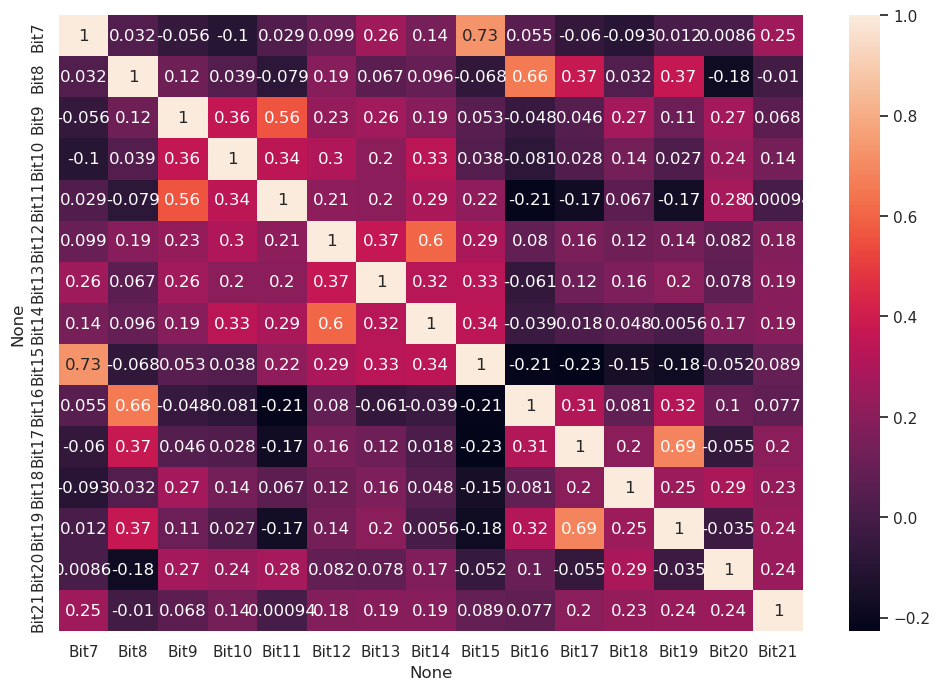

In [126]:
# 4. Checking correlation
# I splitted dataset because there are lots of variables, which each of dataset including class column.

split1 = [i for i in range(7,22)]
split2 = [i for i in range(50,65)]

df1 = df.iloc[:, split1]
df2 = df.iloc[:, split2]

plt.subplots(figsize=(12,8))
sns.heatmap(df1.corr(), annot=True)


<AxesSubplot:xlabel='None', ylabel='None'>

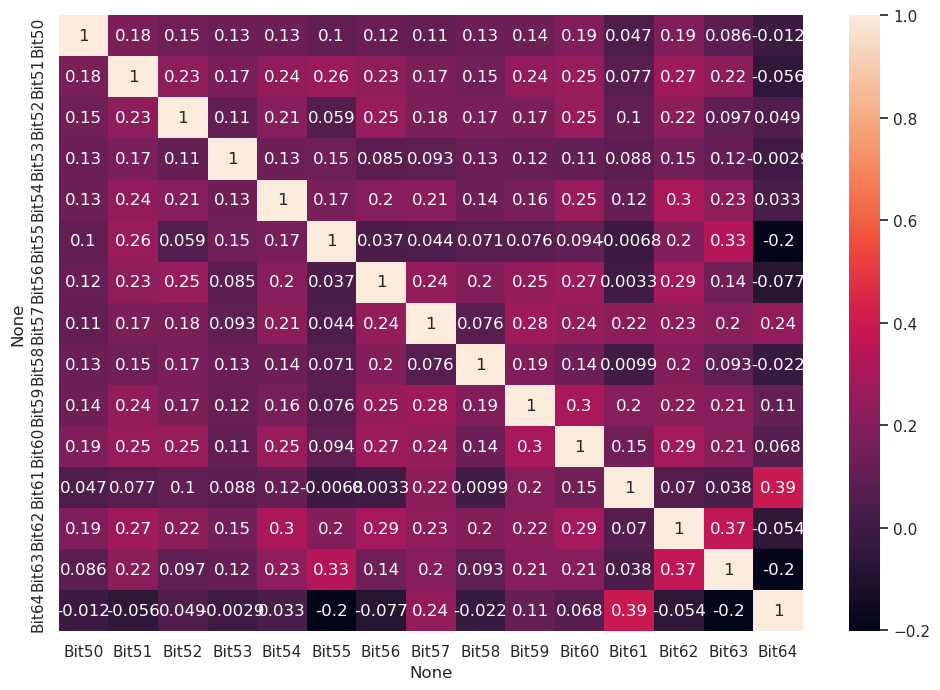

In [127]:
plt.subplots(figsize=(12,8))
sns.heatmap(df2.corr(), annot=True)

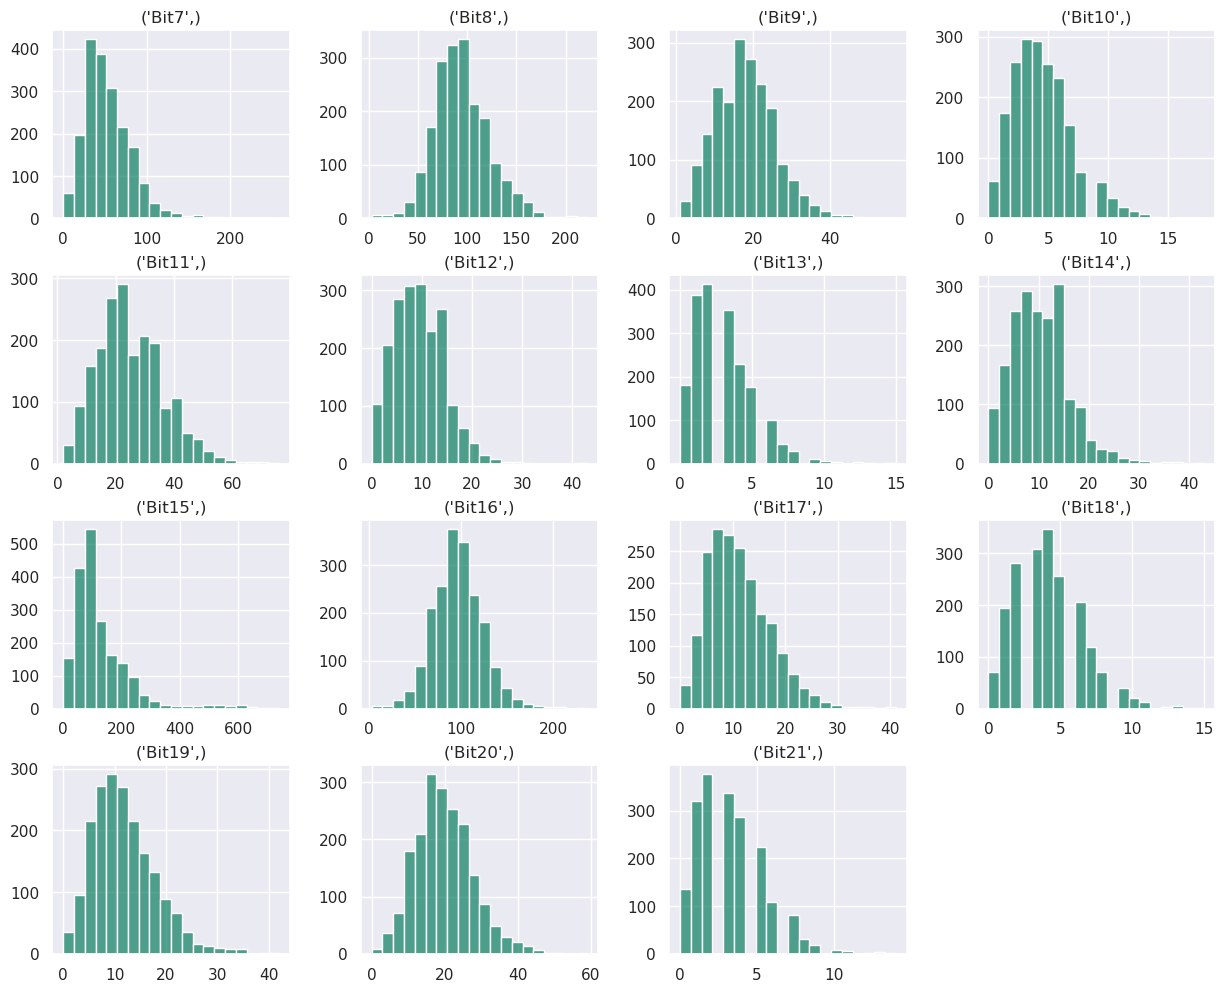

In [128]:
# 5. Checking data distribution

df1.hist(figsize=(15,12),bins = 20, color="#007959AA")
plt.show()

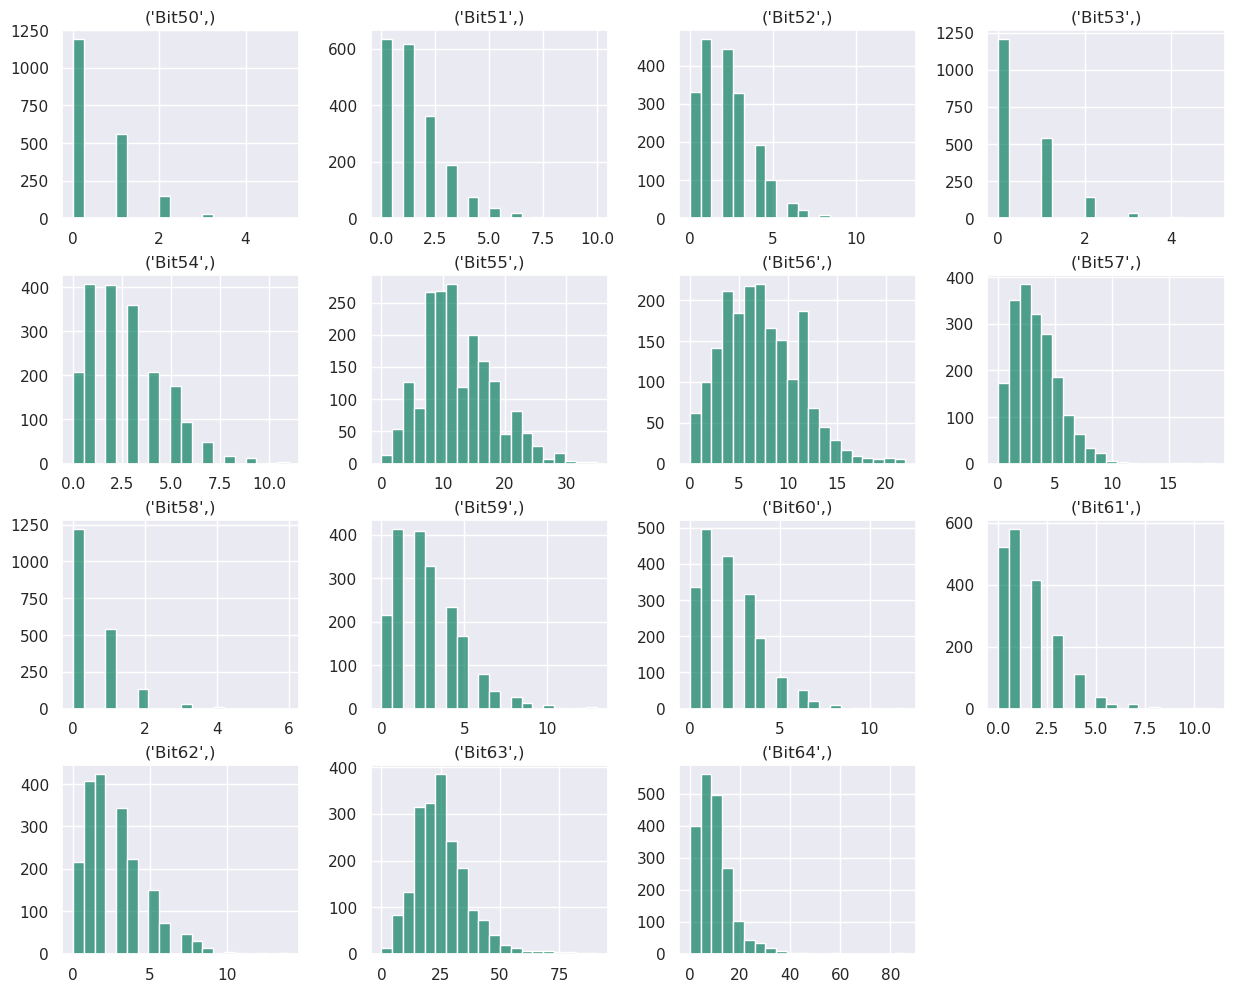

In [129]:
df2.hist(figsize=(15,12),bins = 20, color="#007959AA")
plt.show()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(1, 0, '(Bit7,)'),
  Text(2, 0, '(Bit8,)'),
  Text(3, 0, '(Bit9,)'),
  Text(4, 0, '(Bit10,)'),
  Text(5, 0, '(Bit11,)'),
  Text(6, 0, '(Bit12,)'),
  Text(7, 0, '(Bit13,)'),
  Text(8, 0, '(Bit14,)'),
  Text(9, 0, '(Bit15,)'),
  Text(10, 0, '(Bit16,)'),
  Text(11, 0, '(Bit17,)'),
  Text(12, 0, '(Bit18,)'),
  Text(13, 0, '(Bit19,)'),
  Text(14, 0, '(Bit20,)'),
  Text(15, 0, '(Bit21,)')])

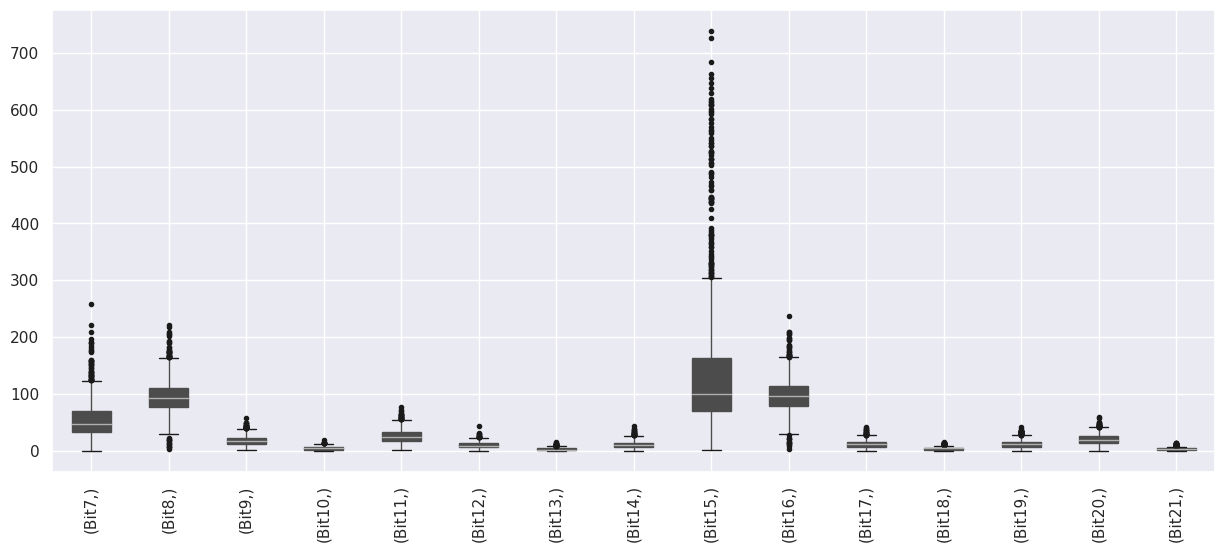

In [130]:
plt.subplots(figsize=(15,6))
df1.boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(1, 0, '(Bit50,)'),
  Text(2, 0, '(Bit51,)'),
  Text(3, 0, '(Bit52,)'),
  Text(4, 0, '(Bit53,)'),
  Text(5, 0, '(Bit54,)'),
  Text(6, 0, '(Bit55,)'),
  Text(7, 0, '(Bit56,)'),
  Text(8, 0, '(Bit57,)'),
  Text(9, 0, '(Bit58,)'),
  Text(10, 0, '(Bit59,)'),
  Text(11, 0, '(Bit60,)'),
  Text(12, 0, '(Bit61,)'),
  Text(13, 0, '(Bit62,)'),
  Text(14, 0, '(Bit63,)'),
  Text(15, 0, '(Bit64,)')])

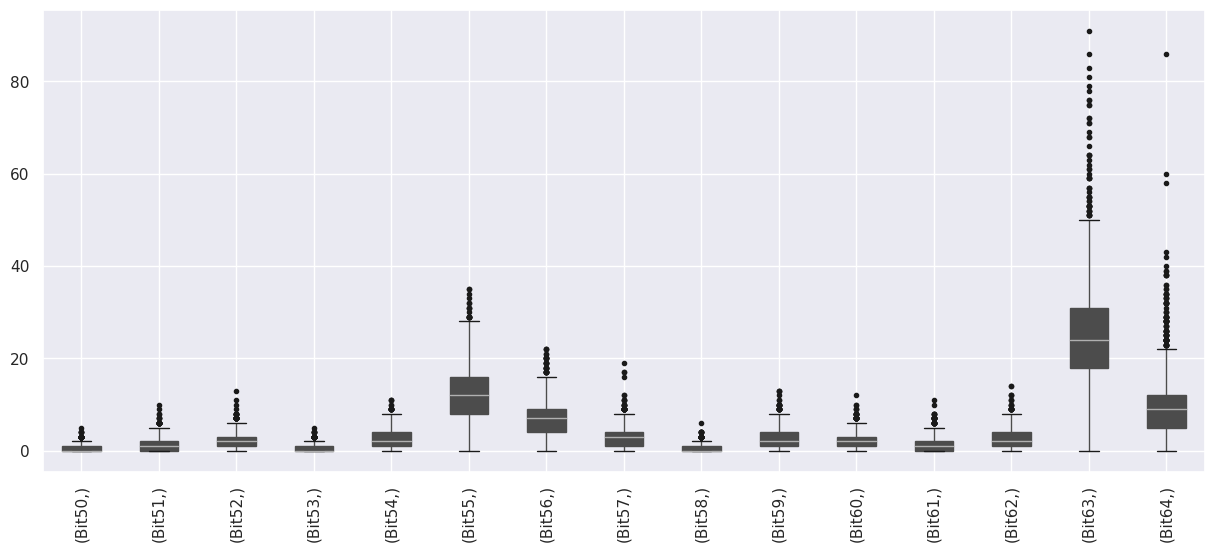

In [132]:
plt.subplots(figsize=(15,6))
df2.boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

Skewness: 2.411303


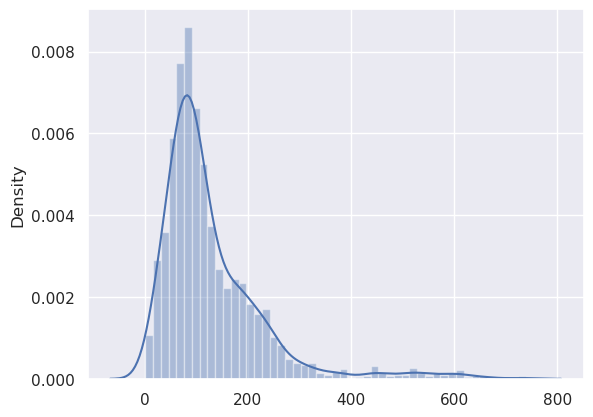

In [133]:
sns.distplot(df['Bit15'])
print("Skewness: %f" % df['Bit15'].skew())

Skewness: 1.414223


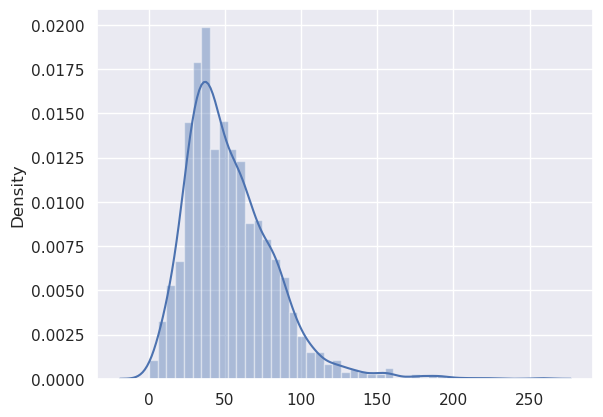

In [134]:
sns.distplot(df['Bit7'])
print("Skewness: %f" % df['Bit7'].skew())

# 3. Pre-Processing

1. Data copy

df = dataset.copy()
df.head()

2. Checking skewness which is over 1

from scipy.stats import skew
features_index = df.dtypes[df.dtypes != 'object'].index

skew_features = df[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features> 1]
print(skew_features_top.sort_values(ascending=False))

sns.distplot(df['degree_spondylolisthesis'])
print("Skewness: %f" % df['degree_spondylolisthesis'].skew())

3. Removing outliers

4. Scaling

5. Use the most important variables


In [135]:
# 1. Checking skewness which is over 1

df_new = df.copy()
df_new.head()

,Bit0,Bit1,Bit2,Bit3,Bit4,Bit5,Bit6,Bit7,Bit8,Bit9,...,Bit247,Bit248,Bit249,Bit250,Bit251,Bit252,Bit253,Bit254,Bit255,class
0,363.0,7.0,9.0,11.0,10.0,2.0,12.0,52.0,127.0,13.0,...,121.0,188.0,19.0,5.0,6.0,15.0,4.0,9.0,181.0,0.0
1,406.0,11.0,5.0,10.0,25.0,5.0,13.0,35.0,75.0,8.0,...,135.0,44.0,13.0,0.0,24.0,32.0,23.0,41.0,368.0,0.0
2,388.0,9.0,10.0,8.0,6.0,3.0,8.0,87.0,163.0,17.0,...,135.0,106.0,22.0,1.0,13.0,15.0,7.0,10.0,260.0,0.0
3,436.0,15.0,10.0,16.0,16.0,3.0,15.0,35.0,120.0,35.0,...,157.0,76.0,29.0,3.0,33.0,23.0,10.0,28.0,283.0,0.0
4,361.0,5.0,19.0,5.0,19.0,1.0,11.0,31.0,63.0,6.0,...,126.0,72.0,28.0,2.0,29.0,31.0,30.0,22.0,238.0,0.0


In [136]:
# Checking skewness

features_index = df_new.dtypes[df_new.dtypes != 'object'].index
skew_features = df_new[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

Bit66     8.256693
Bit189    7.726811
class     4.052707
Bit248    3.634045
Bit148    3.585594
            ...   
Bit52     1.007459
Bit22     1.007227
Bit136    1.005767
Bit233    1.005345
Bit158    1.002894
Length: 172, dtype: float64


Skewness: 8.263093


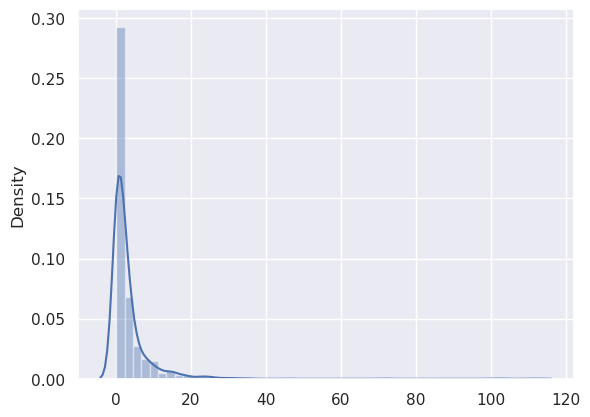

In [137]:
sns.distplot(df_new['Bit66'])
print("Skewness: %f" % df['Bit66'].skew())

In [138]:
# 2. Removing outliers
# detecting Outlier
# Inter Quartile Range is the distance between the 3rd Quartile and the first Qartile

def detect_outlier(X):
    #X = df_new.iloc[:, :-1]
    #for i in range(len(X.columns)):
    for i in range(5): # Only priny the firs 5
        first_q = np.percentile(X[X.columns[i]], 25)
        third_q = np.percentile(X[X.columns[i]], 75) 
        IQR = 1.5*(third_q - first_q)
        minimum = first_q - IQR 
        maximum = third_q + IQR
        
        if(minimum > np.min(X[X.columns[i]]) or maximum < np.max(X[X.columns[i]])):
            print(X.columns[i], "There is Outlier")

def remove_outlier(X):
    #X = df_new.iloc[:, :-1]
    for i in range(len(X.columns)):
        first_q = np.percentile(X[X.columns[i]], 25)
        third_q = np.percentile(X[X.columns[i]], 75) 
        IQR = 1.5*(third_q - first_q)
        minimum = first_q - IQR 
        maximum = third_q + IQR
    
        median = X[X.columns[i]].median()
    
        X.loc[X[X.columns[i]] < minimum, X.columns[i]] = median 
        X.loc[X[X.columns[i]] > maximum, X.columns[i]] = median

In [139]:
X = df_new.iloc[:, :-1]
detect_outlier(X)
remove_outlier(X)

('Bit0',) There is Outlier
('Bit1',) There is Outlier
('Bit2',) There is Outlier
('Bit3',) There is Outlier
('Bit4',) There is Outlier


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(1, 0, '(Bit7,)'),
  Text(2, 0, '(Bit8,)'),
  Text(3, 0, '(Bit9,)'),
  Text(4, 0, '(Bit10,)'),
  Text(5, 0, '(Bit11,)'),
  Text(6, 0, '(Bit12,)'),
  Text(7, 0, '(Bit13,)'),
  Text(8, 0, '(Bit14,)'),
  Text(9, 0, '(Bit15,)'),
  Text(10, 0, '(Bit16,)'),
  Text(11, 0, '(Bit17,)'),
  Text(12, 0, '(Bit18,)'),
  Text(13, 0, '(Bit19,)'),
  Text(14, 0, '(Bit20,)'),
  Text(15, 0, '(Bit21,)')])

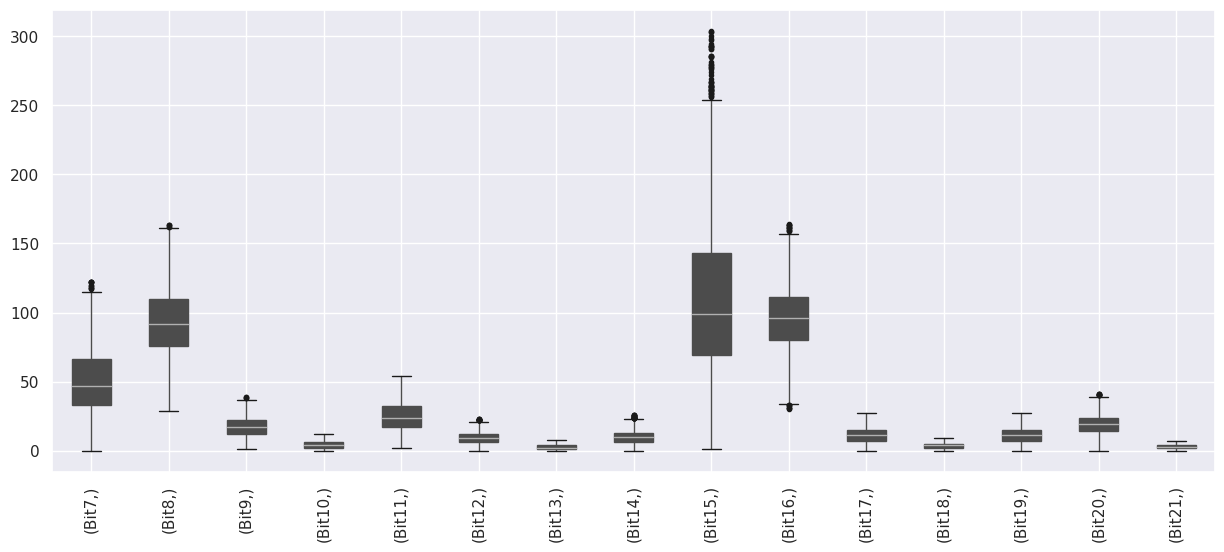

In [140]:
plt.subplots(figsize=(15,6))
X.iloc[:, 7:22].boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 [Text(1, 0, '(Bit50,)'),
  Text(2, 0, '(Bit51,)'),
  Text(3, 0, '(Bit52,)'),
  Text(4, 0, '(Bit53,)'),
  Text(5, 0, '(Bit54,)'),
  Text(6, 0, '(Bit55,)'),
  Text(7, 0, '(Bit56,)'),
  Text(8, 0, '(Bit57,)'),
  Text(9, 0, '(Bit58,)'),
  Text(10, 0, '(Bit59,)'),
  Text(11, 0, '(Bit60,)'),
  Text(12, 0, '(Bit61,)'),
  Text(13, 0, '(Bit62,)'),
  Text(14, 0, '(Bit63,)'),
  Text(15, 0, '(Bit64,)'),
  Text(16, 0, '(Bit65,)'),
  Text(17, 0, '(Bit66,)'),
  Text(18, 0, '(Bit67,)'),
  Text(19, 0, '(Bit68,)'),
  Text(20, 0, '(Bit69,)')])

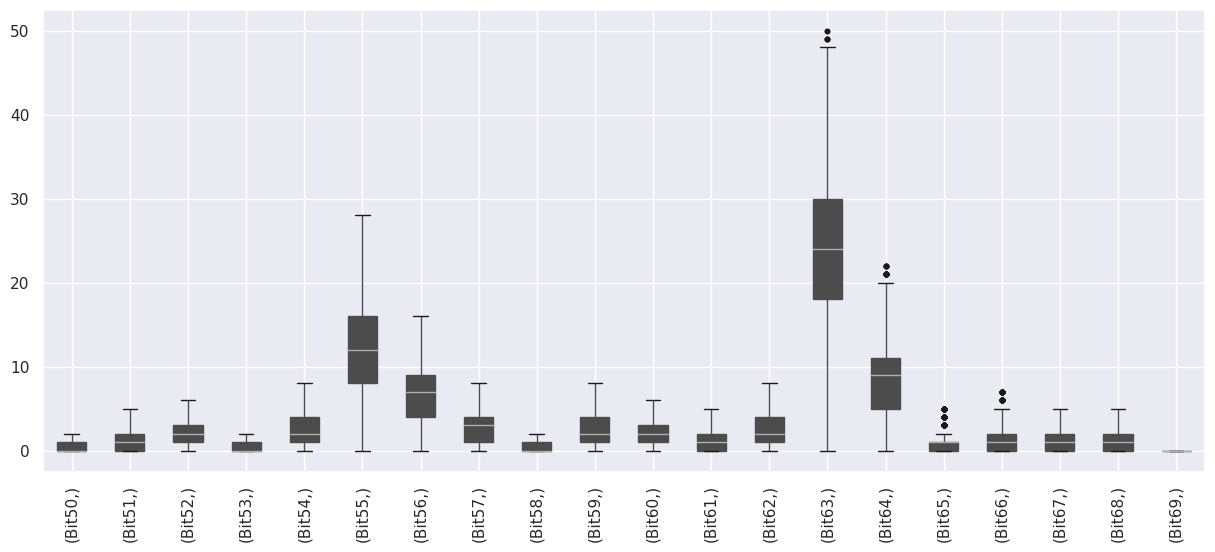

In [141]:
plt.subplots(figsize=(15,6))
X.iloc[:, 50:70].boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

In [142]:
# 3. Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)
scaled_df = pd.DataFrame(data = scaled_data, columns = X.columns)
scaled_df.head()

,Bit0,Bit1,Bit2,Bit3,Bit4,Bit5,Bit6,Bit7,Bit8,Bit9,...,Bit246,Bit247,Bit248,Bit249,Bit250,Bit251,Bit252,Bit253,Bit254,Bit255
0,0.390625,0.318182,0.346154,0.44,0.40,0.333333,0.413793,0.426230,0.731343,0.315789,...,0.068182,0.572464,0.781513,0.38,0.416667,0.125000,0.304348,0.12500,0.177778,0.243499
1,0.726562,0.500000,0.192308,0.40,1.00,0.833333,0.448276,0.286885,0.343284,0.184211,...,0.681818,0.673913,0.176471,0.26,0.000000,0.500000,0.673913,0.71875,0.888889,0.685579
2,0.585938,0.409091,0.384615,0.32,0.24,0.500000,0.275862,0.713115,1.000000,0.421053,...,0.272727,0.673913,0.436975,0.44,0.083333,0.270833,0.304348,0.21875,0.200000,0.430260
3,0.960938,0.681818,0.384615,0.64,0.64,0.500000,0.517241,0.286885,0.679104,0.894737,...,0.568182,0.833333,0.310924,0.58,0.250000,0.687500,0.478261,0.31250,0.600000,0.484634
4,0.375000,0.227273,0.730769,0.20,0.76,0.166667,0.379310,0.254098,0.253731,0.131579,...,0.840909,0.608696,0.294118,0.56,0.166667,0.604167,0.652174,0.93750,0.466667,0.378251


In [143]:
# Check skewness after remove outliers and normalizing
X = scaled_df
features_index = X.dtypes[X.dtypes != 'object'].index
skew_features = X[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features> 0]
print(skew_features_top.sort_values(ascending=False))

Bit164    1.758509
Bit85     1.669608
Bit37     1.667554
Bit186    1.597198
Bit173    1.575342
            ...   
Bit30     0.239645
Bit9      0.215885
Bit246    0.188631
Bit239    0.106286
Bit16     0.073111
Length: 242, dtype: float64


Skewness: 1.289094


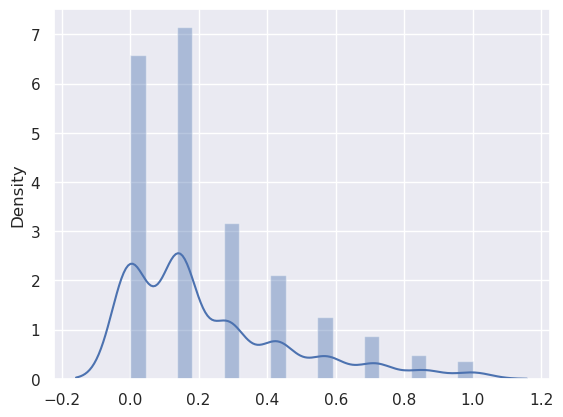

In [144]:
sns.distplot(X['Bit66'])
print("Skewness: %f" % X['Bit66'].skew())

In [155]:
# 3. Variable selection

X = scaled_df
y = df_new.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

log_rg = LogisticRegression().fit(X_train, y_train)
#scores = cross_val_score(log_rg, X_train, y_train, cv=5)
#print(scores)
#print(log_rg.score(X_test, y_test))
print(classification_report(y_test, log_rg.predict(X_test)))
#print(len(log_rg.coef_[0]))


              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       366
         1.0       0.84      0.73      0.78        22

    accuracy                           0.98       388
   macro avg       0.91      0.86      0.88       388
weighted avg       0.98      0.98      0.98       388



In [162]:
# The importance variable selection will be done by usign coeficient:

feature_importance_lr = pd.DataFrame(zip(X.columns.values, log_rg.coef_.ravel()))
feature_importance_lr.columns = ['feature', 'coef']
feature_importance_lr.sort_values("coef", ascending=False, inplace=True)
feature_importance_lr.where(feature_importance_lr["coef"] >0.75).head(10)

,feature,coef
35,"(Bit35,)",1.378371
244,"(Bit244,)",1.169080
255,"(Bit255,)",1.165189
129,"(Bit129,)",0.904827
8,"(Bit8,)",0.769962
70,NaN,NaN
3,NaN,NaN
230,NaN,NaN
47,NaN,NaN
194,NaN,NaN


In [164]:
# So according to this we only will use variable Bit35, Bit244, Bit255, Bit129, Bit8
X = scaled_df[["Bit35", "Bit244", "Bit255", "Bit129", "Bit8"]]
y = df_new.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1937, 5), (1937,), (1549, 5), (388, 5), (1549,), (388,))

In [201]:
!pip3 install imblearn

In [2]:
from imblearn.over_sampling import SMOTE

In [196]:
# Modeling

In [166]:

def print_accuracy(accuracy_score, score_text=False):
    clean_accuracy = accuracy_score*100.0
    if score_text:
        clean_text = score_text.strip() + ' '
        print('{}{:.2f}%'.format(clean_text, clean_accuracy))
    else:
        print('{:.2f}%'.format(clean_accuracy))

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test ,pred)
    rmse = np.sqrt(mse)
    print('{0} MSE : {1}'.format(model.__class__.__name__,np.round(mse, 2)))
    print('{0} RMSE : {1}'.format(model.__class__.__name__,np.round(rmse, 2)))
    return mse, rmse

## 1. Desicion Tree Model

In [167]:
# Using Grid Serach CV

# max_depth : (1,10)
# max_featues : (1,8)
# min_samples_leaf : (1,11)
# CV = 10

DT_model = DecisionTreeClassifier(random_state = 1000).fit(X_train, y_train)
tree_pred = DT_model.predict(X_test)
print_accuracy(accuracy_score(y_test, tree_pred), 'Decision tree accuracy:')

Decision tree accuracy: 94.59%


In [ ]:

DT_model = DecisionTreeClassifier(random_state = 1000)
param_grid = {'max_depth': [i for i in range(1, 11)], 
              'max_features': [i for i in range(1, 8)], 
              'min_samples_leaf': [i for i in range(1, 11)]}
dt_grid = GridSearchCV(DT_model, param_grid=param_grid, cv=10, return_train_score = True, n_jobs=-1)
dt_grid.fit(X_train, y_train)

In [170]:
print("Best Score: {}%".format(round(dt_grid.best_score_*100.0, 2)))
print("Best params: {}".format(dt_grid.best_params_))

Best Score: 98.45%
Best params: {'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 1}


In [172]:
y_pred = dt_grid.best_estimator_.predict(X_test)
print_accuracy(accuracy_score(y_test,y_pred), 'Decision Tree Classifier:')

Decision Tree Classifier: 95.88%


In [173]:
get_rmse(tree_model)
print('')
get_rmse(dt_grid)

NameError: name 'tree_model' is not defined

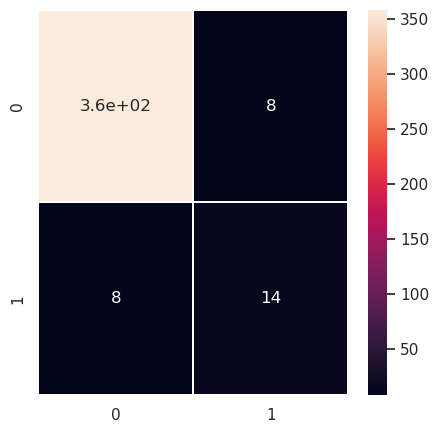

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       366
         1.0       0.64      0.64      0.64        22

    accuracy                           0.96       388
   macro avg       0.81      0.81      0.81       388
weighted avg       0.96      0.96      0.96       388



In [175]:
cm = confusion_matrix(y_test,dt_grid.predict(X_test))

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=.3)
plt.show()

print(classification_report(y_test,dt_grid.predict(X_test)))

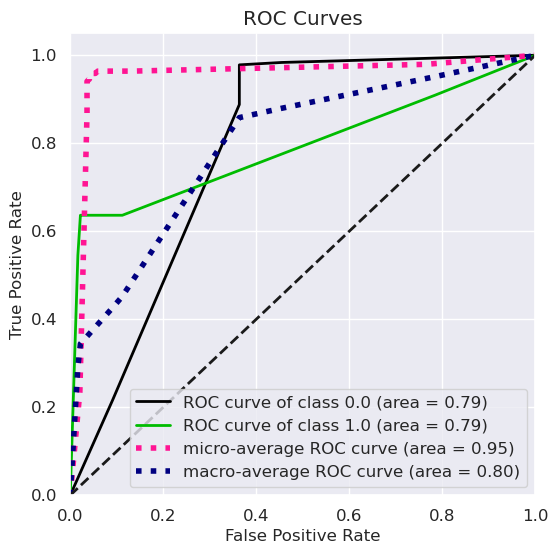

Auc Score: 0.8072528564331842


In [179]:
from sklearn.metrics import roc_auc_score
import scikitplot as skplt

skplt.metrics.plot_roc_curve(y_test,dt_grid.predict_proba(X_test),figsize=(6,6))
plt.show()

print("Auc Score: {}".format(roc_auc_score(y_test,dt_grid.predict(X_test))))